In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from IPython.display import display
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import seaborn as sns
import multiprocessing as mp

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/another-final-full-bureau-col/train.csv
/kaggle/input/another-final-full-bureau-col/test.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_columns_description.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_sample_submission.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset/dseb63_previous_application.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset/dseb63_bureau_balance.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset/dseb63_credit_card_balance.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset/dseb63_POS_CASH_balance.csv
/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset/dseb63_installments_payme

In [2]:
import os
import gc

# TRANSFORM 4 TABLES: CREDIT_CARD_BALANCE, INSTALLMENTS_PAYMENTS, POS_CASH and PREVIOUS_APPLICATION

In this section, we encode and create new features for these four tables.

In [3]:
from scipy.stats import kurtosis, iqr, skew


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    '''
    Add new features to a dataframe groupby object.
        Input:
            features : dict
                Dictionary to store new features.
            gr_ : pandas.DataFrame
                Dataframe groupby object.
            feature_name : str
                Column name to calculate statistics.
            aggs : list
                List of method to calculate statistics.
            prefix : str
                Prefix of column names.
        Output:
            features : dict
                Dictionary with new features.
        '''
    for agg in aggs:
        if agg == 'sum':
            features[f'{prefix}{feature_name}_sum'] = gr_[
                feature_name].sum()
        elif agg == 'mean':
            features[f'{prefix}{feature_name}_mean'] = gr_[
                feature_name].mean()
        elif agg == 'max':
            features[f'{prefix}{feature_name}_max'] = gr_[
                feature_name].max()
        elif agg == 'min':
            features[f'{prefix}{feature_name}_min'] = gr_[
                feature_name].min()
        elif agg == 'std':
            features[f'{prefix}{feature_name}_std'] = gr_[
                feature_name].std()
        elif agg == 'count':
            features[f'{prefix}{feature_name}_count'] = gr_[
                feature_name].count()
        elif agg == 'skew':
            features[f'{prefix}{feature_name}_skew'] = skew(
                gr_[feature_name])
        elif agg == 'kurt':
            features[f'{prefix}{feature_name}_kurt'] = kurtosis(
                gr_[feature_name])
        elif agg == 'iqr':
            features[f'{prefix}{feature_name}_iqr'] = iqr(
                gr_[feature_name])
        elif agg == 'median':
            features[f'{prefix}{feature_name}_median'] = gr_[
                feature_name].median()
    return features


def installments_last_loan_features(gr):
    '''
    Calculate features for the last loan in installments_payments.csv.
        Input:
            gr : pandas.DataFrame
                DataFrame groupby object.
        Output:
            features : dict
                Dictionary with new features.
    '''
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features


def add_ratios_features(df):
    '''
    Calculate several ratios for the main dataset.
        Input:
            df : pandas.DataFrame
                Dataframe after merge with all other dataframes.
        Output:
            df : pandas.DataFrame
                Final ataframe with ratios added.
    '''

    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / \
        df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / \
        df['AMT_INCOME_TOTAL']

    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / \
        df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / \
        df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']

    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / \
        df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / \
        df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']

    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / \
        df['CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / \
        df['CREDIT_TO_ANNUITY_RATIO']

    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / \
        df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / \
        df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / \
        df['DAYS_EMPLOYED']
    return df


In [4]:
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns using get dummies. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [
            col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


In [5]:
def group(df_to_agg, prefix, aggregations, aggregate_by='SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by='SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by=aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on=aggregate_by)
PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],

    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],

    'CNT_PAYMENT': ['max', 'mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],

    'DAYS_TERMINATION': ['max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],

    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],

    'NEW_CREDIT_GOODS_RATE': ['mean', 'max', 'var', 'min'],
    'NEW_END_DIFF': ['min', 'max'],
    'NEW_DAYS_DUE_DIFF': ['min', 'max'],
    'NEW_RETURN_DAY': ['min', 'max'],

    'RATE_DOWN_PAYMENT': ['max', 'mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],

    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'AMT_PAYMENT': ['sum'],

    'CNT_PAYMENT': ['mean', 'sum'],

    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],

    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],

    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],

    'SIMPLE_INTERESTS': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],

    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'AMT_INTEREST': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],

    'CNT_PAYMENT': ['max', 'mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],

    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],

    'HOUR_APPR_PROCESS_START': ['min', 'max'],

    'INTEREST_SHARE': ['min', 'max', 'mean'],
    'INTEREST_RATE': ['min', 'max', 'mean'],

    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],

    'CNT_PAYMENT': ['max', 'mean'],

    'DAYS_DECISION': ['min', 'max', 'mean'],

    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'APPLICATION_CREDIT_DIFF': ['min'],

    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],

    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],

    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],

    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
}
PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],

    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],

    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],

    'SIMPLE_INTERESTS': ['mean', 'max'],
}


## PREVIOUS_APPLICATION

In [6]:
def previous_application(path_to_data):
    """ Process mainly on dseb63_previous_application.csv and and merge with 
    some solumns of dseb63_installments_payments.csv for insights return a pandas dataframe. """
    # Read data dseb63_previous_application.csv and dseb63_installments_payments.csv
    prev = pd.read_csv(os.path.join(
        path_to_data, 'dseb63_previous_application.csv'))
    pay = pd.read_csv(os.path.join(
        path_to_data, 'dseb63_installments_payments.csv'))

    # One-hot encode most important categorical features
    enc_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(
        prev, enc_columns, nan_as_category=False)

    new_coding = {"0": "Yes", "1": "No"}
    # Calculate ratios and difference for some columns
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']

    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    prev["NEW_APP_CREDIT_RATE_RATIO"] = prev["APPLICATION_CREDIT_RATIO"].apply(
        lambda x: 1 if (x <= 1) else 0)
    prev['NEW_APP_CREDIT_RATE_RATIO'] = prev['NEW_APP_CREDIT_RATE_RATIO'].astype(
        'O')
    prev['NEW_APP_CREDIT_RATE_RATIO'] = prev['NEW_APP_CREDIT_RATE_RATIO'].replace(
        new_coding)

    prev["NEW_CNT_PAYMENT"] = pd.cut(x=prev['CNT_PAYMENT'], bins=[
                                     0, 12, 60, 120], labels=["Short", "Middle", "Long"])
    prev['NEW_CREDIT_GOODS_RATE'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']

    prev["NEW_END_DIFF"] = prev["DAYS_TERMINATION"] - prev["DAYS_LAST_DUE"]
    prev['NEW_DAYS_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - \
        prev['DAYS_FIRST_DUE']
    prev['NEW_RETURN_DAY'] = prev['DAYS_DECISION'] + prev['CNT_PAYMENT'] * 30
    prev['NEW_DAYS_TERMINATION_DIFF'] = prev['DAYS_TERMINATION'] - \
        prev['NEW_RETURN_DAY']

    prev['NFLAG_LAST_APPL_IN_DAY'] = prev['NFLAG_LAST_APPL_IN_DAY'].astype("O")

    # Interest ratio on previous application
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (
        total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
    prev['AMT_INTEREST'] = prev['CNT_PAYMENT'] * \
        prev['AMT_ANNUITY'] - prev['AMT_CREDIT']
    prev['INTEREST_SHARE'] = prev['AMT_INTEREST'] / \
        (prev['AMT_CREDIT'] + 0.00001)  # smoothing to avoid division by zero
    prev['INTEREST_RATE'] = 2 * 12 * prev['AMT_INTEREST'] / \
        (prev['AMT_CREDIT'] * (prev['CNT_PAYMENT'] + 1))

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]

    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby(
        'SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace=True)

    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - \
        active_pay_agg['AMT_PAYMENT']

    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on='SK_ID_PREV', how='left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - \
        active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / \
        active_df['AMT_CREDIT']

    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM'] /\
        active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - \
        prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - \
        approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}

    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})

    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df

    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(
        approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(
        refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused

    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev[f'NAME_CONTRACT_TYPE_{loan_type}'] == 1]
        prefix = 'PREV_' + loan_type.split(" ", maxsplit=1)[0] + '_'
        agg_prev = group_and_merge(
            type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
    del type_df

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(
        lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()

    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                              'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id

    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = f'PREV_LAST{time_frame}M_'
        agg_prev = group_and_merge(
            time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df

    del prev
    gc.collect()
    return agg_prev


In [7]:
path = '/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset/'

In [8]:
prev = previous_application(path)

/tmp/ipykernel_13/242145600.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prev['NEW_APP_CREDIT_RATE_RATIO'] = prev['NEW_APP_CREDIT_RATE_RATIO'].replace(
/tmp/ipykernel_13/242145600.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=

In [9]:
def do_sum(dataframe, group_cols, counted, agg_name):
    gp = dataframe[group_cols + [counted]].groupby(
        group_cols)[counted].sum().reset_index().rename(columns={counted: agg_name})
    dataframe = dataframe.merge(gp, on=group_cols, how='left')
    return dataframe

## POS_CASH

In [10]:
POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SK_ID_CURR': ['count'],

    'EXP_CNT_INSTALMENT': ['last', 'min', 'max', 'mean', 'sum'],
    'EXP_CNT_INSTALMENT_FUTURE': ['last', 'min', 'max', 'mean', 'sum'],

    'LATE_PAYMENT': ['mean'],

    'MONTHS_BALANCE': ['min', 'max', 'size'],

    'POS_IS_DPD': ['mean', 'sum'],
    'POS_IS_DPD_UNDER_120': ['mean', 'sum'],
    'POS_IS_DPD_OVER_120': ['mean', 'sum'],

    'SK_DPD': ['max', 'mean', 'sum', 'var', 'min'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
}

In [11]:
def pos_cash(path_to_data):
    """ Process dseb63_POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(
        path_to_data, 'dseb63_POS_CASH_balance.csv'))

    # computing Exponential Moving Average for some features based on MONTHS_BALANCE
    columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
    exp_columns = ['EXP_'+ele for ele in columns_for_ema]
    pos[exp_columns] = pos.groupby('SK_ID_PREV')[columns_for_ema].transform(
        lambda x: x.ewm(alpha=0.6).mean())

    # One-hot encode categorical features
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category=False)

    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

    # Flag days past due
    pos['POS_IS_DPD'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

    # Flag days past due less than 120 days
    pos['POS_IS_DPD_UNDER_120'] = pos['SK_DPD'].apply(
        lambda x: 1 if (x > 0) & (x < 120) else 0)

    # Flag days past due over 120 days
    pos['POS_IS_DPD_OVER_120'] = pos['SK_DPD'].apply(
        lambda x: 1 if x >= 120 else 0)

    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})

    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')

    # Create new dataframe to store features calculated from gp
    df = pd.DataFrame()

    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - \
        gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                               and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)

    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last() / \
        gp['CNT_INSTALMENT'].last()

    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace=True)
    pos_agg = pd.merge(pos_agg, df_gp, on='SK_ID_CURR', how='left')
    del df, gp, df_gp, sort_pos

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)

    # Average application features over the last 3 applications
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(
        pos_agg, gp_mean[['SK_ID_CURR', 'LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features, which were created to calculate to other features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    del gp, gp_mean, sort_pos, pos
    gc.collect()
    return pos_agg


In [12]:
pos_agg = pos_cash(path)

## INSTALLMENTS_PAYMENTS

In [13]:
def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0:
        num_workers = 4
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features

def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_

def installments_last_loan_features(gr):
    '''
    Calculate features for the last loan in installments_payments.csv.
        Input:
            gr : pandas.DataFrame
                DataFrame groupby object.
        Output:
            features : dict
                Dictionary with new features.
    '''
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features

In [14]:
INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],

    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],

    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],

    'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
    'INS_IS_DPD_OVER_120': ['mean', 'sum'],

    'LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],

    'PAID_OVER': ['mean'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],

    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],

    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],

    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],

    'LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],

    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],

    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
}


In [15]:
def installment(path_to_data):
    """ Process dseb63_installments_payments.csv and return a pandas dataframe. """
    # Read data
    pay = pd.read_csv(os.path.join(
        path_to_data, 'dseb63_installments_payments.csv'))

    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'],
                 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - \
        pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)

    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)

    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)

    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(
        lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(
        lambda x: 1 if x > 0.05 else 0)

    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)

    # Flag k threshold late payments over or under 120 days
    pay['INS_IS_DPD_UNDER_120'] = pay['DPD'].apply(
        lambda x: 1 if (x > 0) & (x < 120) else 0)
    pay['INS_IS_DPD_OVER_120'] = pay['DPD'].apply(
        lambda x: 1 if (x >= 120) else 0)

    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [24, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT']
                             >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = f'INS_{months}M_'
        pay_agg = group_and_merge(
            pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

    # Last loan features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    del pay
    g = parallel_apply(gp, installments_last_loan_features,
                       index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    del g, gp
    gc.collect()
    return pay_agg


In [16]:
install_pay = installment(path)

## CREDIT_CARD_BALANCE

In [17]:
CREDIT_CARD_AGG = {
    'AMT_BALANCE': ['sum', 'min', 'max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max', 'sum', 'min'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_DRAWING_SUM': ['sum', 'max'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean', 'min'],
    'AMT_INTEREST_RECEIVABLE': ['min', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean', 'sum'],

    'BALANCE_LIMIT_RATIO': ['mean', 'max', 'min'],

    'CNT_DRAWING_SUM': ['sum', 'max'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean', 'sum', 'max'],

    'EXP_AMT_BALANCE': ['last'],
    'EXP_AMT_CREDIT_LIMIT_ACTUAL': ['last'],
    'EXP_AMT_RECEIVABLE_PRINCIPAL': ['last'],
    'EXP_AMT_RECEIVABLE': ['last'],
    'EXP_AMT_TOTAL_RECEIVABLE': ['last'],
    'EXP_AMT_DRAWING_SUM': ['last'],
    'EXP_BALANCE_LIMIT_RATIO': ['last'],
    'EXP_CNT_DRAWING_SUM': ['last'],
    'EXP_MIN_PAYMENT_RATIO': ['last'],
    'EXP_PAYMENT_MIN_DIFF': ['last'],
    'EXP_MIN_PAYMENT_TOTAL_RATIO': ['last'],
    'EXP_AMT_INTEREST_RECEIVABLE': ['last'],
    'EXP_SK_DPD_RATIO': ['last'],

    'LIMIT_USE': ['max', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],

    'MIN_PAYMENT_RATIO': ['min', 'mean'],
    'MIN_PAYMENT_TOTAL_RATIO': ['min', 'mean'],
    'MONTHS_BALANCE': ['min'],

    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'SK_DPD_RATIO': ['max', 'mean'],

    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'PAYMENT_MIN_DIFF': ['min', 'mean'],
    'PAYMENT_MIN_TOTAL_DIFF': ['min', 'mean'],
}

CREDIT_CARD_TIME_AGG = {
    'AMT_BALANCE': ['mean', 'max'],

    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],

    'EXP_AMT_DRAWING_SUM': ['last'],
    'EXP_BALANCE_LIMIT_RATIO': ['last'],
    'EXP_CNT_DRAWING_SUM': ['last'],
    'EXP_MIN_PAYMENT_RATIO': ['last'],
    'EXP_PAYMENT_MIN_DIFF': ['last'],
    'EXP_MIN_PAYMENT_TOTAL_RATIO': ['last'],
    'EXP_AMT_INTEREST_RECEIVABLE': ['last'],
    'EXP_SK_DPD_RATIO': ['last'],

    'LIMIT_USE': ['max', 'mean'],

    'SK_DPD': ['max', 'sum'],
}

rolling_columns = [
    'AMT_BALANCE',
    'AMT_CREDIT_LIMIT_ACTUAL',
    'AMT_DRAWING_SUM',
    'AMT_INTEREST_RECEIVABLE',
    'AMT_RECEIVABLE',
    'AMT_RECEIVABLE_PRINCIPAL',
    'AMT_TOTAL_RECEIVABLE',

    'BALANCE_LIMIT_RATIO',

    'CNT_DRAWING_SUM',

    'MIN_PAYMENT_RATIO',
    'MIN_PAYMENT_TOTAL_RATIO',

    'PAYMENT_MIN_DIFF',

    'SK_DPD_RATIO']


In [18]:

def credit_card(path_to_data):
    """ Process dseb63_credit_card_balance.csv and return a pandas dataframe. """
    # Read data
    cc = pd.read_csv(os.path.join(
        path_to_data, 'dseb63_credit_card_balance.csv'))

    # One-hot encoder
    cc, _ = one_hot_encoder(cc, nan_as_category=False)

    # Rename columns to correct format
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / \
        cc['AMT_INST_MIN_REGULARITY']

    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / \
        cc['AMT_CREDIT_LIMIT_ACTUAL']

    # Total amount of drawing at ATM
    cc['AMT_DRAWING_SUM'] = cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] + cc[
        'AMT_DRAWINGS_OTHER_CURRENT'] + cc['AMT_DRAWINGS_POS_CURRENT']

    # Total of drawing on previous credit
    cc['CNT_DRAWING_SUM'] = cc['CNT_DRAWINGS_ATM_CURRENT'] + cc['CNT_DRAWINGS_CURRENT'] + \
        cc['CNT_DRAWINGS_OTHER_CURRENT'] + \
        cc['CNT_DRAWINGS_POS_CURRENT'] + cc['CNT_INSTALMENT_MATURE_CUM']

    # ATM balance ratio, with smoothing by 0.00001 to avoid dividing by zero
    cc['BALANCE_LIMIT_RATIO'] = cc['AMT_BALANCE'] / \
        (cc['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)

    # Number of times drawing was done, with smoothing by 0.00001 to avoid dividing by zero
    cc['MIN_PAYMENT_RATIO'] = cc['AMT_PAYMENT_CURRENT'] / \
        (cc['AMT_INST_MIN_REGULARITY'] + 0.0001)
    cc['MIN_PAYMENT_TOTAL_RATIO'] = cc['AMT_PAYMENT_TOTAL_CURRENT'] / \
        (cc['AMT_INST_MIN_REGULARITY'] + 0.00001)

    # Days past due ratio, with smoothing by 0.00001 to avoid dividing by zero
    cc['SK_DPD_RATIO'] = cc['SK_DPD'] / (cc['SK_DPD_DEF'] + 0.00001)

    # Difference in payment min and current
    cc['PAYMENT_MIN_DIFF'] = cc['AMT_PAYMENT_CURRENT'] - \
        cc['AMT_INST_MIN_REGULARITY']

    # Difference in total payment and current
    cc['PAYMENT_MIN_TOTAL_DIFF'] = cc['AMT_PAYMENT_TOTAL_CURRENT'] - \
        cc['AMT_INST_MIN_REGULARITY']

    # Interest received
    cc['AMT_INTEREST_RECEIVABLE'] = cc['AMT_TOTAL_RECEIVABLE'] - \
        cc['AMT_RECEIVABLE_PRINCIPAL']

    # calculating the rolling Exponential Weighted Moving Average over months for certain features
    exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
    cc[exp_weighted_columns] = cc.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[
        rolling_columns].transform(lambda x: x.ewm(alpha=0.7).mean())

    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace=True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df, cc_agg, 'CC_LAST_', {
                             'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = f'INS_{months}M_'
        cc_agg = group_and_merge(
            cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)

    del cc_recent, cc_prev_id, last_months_df, last_ids, cc
    gc.collect()
    return cc_agg


In [19]:
cc = credit_card(path)

# AGGREGATE ALL TABLES

We have merged the bureau and bureau_balance outside this notebook. The application_train and application_test were merged for encoding and feature engineering (we handle outliers and missing values of each table separately before merging).

In [20]:
bureau_merged=pd.read_csv('/kaggle/input/bureau-merge-full-col/bureau_merge_no_drop and full col.csv')
application_merged= pd.read_csv('/kaggle/input/feature-eng/FeatureEngineering.csv')

In [21]:
# Merge bureau_merge
train_test_merge = pd.merge(application_merged, bureau_merged, on='SK_ID_CURR', how='left')
print(train_test_merge.shape)

# Merge credit_card_balance
train_test_merge = pd.merge(train_test_merge, cc, on='SK_ID_CURR', how='left')
print(train_test_merge.shape)

# Merge pos
train_test_merge = pd.merge(train_test_merge, pos_agg, on='SK_ID_CURR', how='left')
print(train_test_merge.shape)

# Merge prev_app_agg
train_test_merge = pd.merge(train_test_merge, prev, on='SK_ID_CURR', how='left')
print(train_test_merge.shape)

# Merge install_pay_agg
train_test_merge = pd.merge(train_test_merge, install_pay, on='SK_ID_CURR', how='left')
train_test_merge.shape

(307511, 352)
(307511, 474)
(307511, 515)
(307511, 756)


(307511, 852)

In [22]:
train_test_merge.drop('Unnamed: 0',axis= 1, inplace= True)
train_test_merge.shape

(307511, 851)

# CHECK MISSING VALUES OF MERGED DATASET

In [23]:
def check_nan(col):
    num_nan = col.isnull().sum()
    num_per = num_nan/len(col) * 100
    col_miss = pd.concat([num_nan, num_per], axis=1, keys=['number_of_NaN', 'percentage_of_NaN']).sort_values(by='percentage_of_NaN', ascending = False).round(1)
    col_miss = col_miss[col_miss['number_of_NaN'] != 0]
    print('Num fields: ', col.shape[1])
    print('Num missing fields: ', col_miss.shape[0])
    return col_miss
check_nan(train_test_merge)[:40]

Num fields:  851
Num missing fields:  702


,number_of_NaN,percentage_of_NaN
BUREAU_MICROLOAN_DEBT_CREDIT_LIMIT_DIFF_MEAN,306640,99.7
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,306640,99.7
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,306640,99.7
BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,305202,99.2
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MEAN,305068,99.2
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MAX,305068,99.2
BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,304540,99.0
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,304540,99.0
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,304540,99.0
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,304540,99.0


In [24]:
train=train_test_merge.head(246009)
test=train_test_merge.tail(61502)

In [106]:
#train.to_csv('train_original.csv',index=False)
#test.to_csv('test_original.csv', index=False)

In [28]:
check_nan(train)[:50]

Num fields:  851
Num missing fields:  702


,number_of_NaN,percentage_of_NaN
BUREAU_MICROLOAN_DEBT_CREDIT_LIMIT_DIFF_MEAN,245293,99.7
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,245293,99.7
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,245293,99.7
BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,244139,99.2
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MEAN,244023,99.2
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MAX,244023,99.2
BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,243605,99.0
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,243605,99.0
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,243605,99.0
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,243605,99.0


In [35]:
check_nan(test)[:60]

Num fields:  851
Num missing fields:  702


,number_of_NaN,percentage_of_NaN
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,61347,99.7
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,61347,99.7
BUREAU_MICROLOAN_DEBT_CREDIT_LIMIT_DIFF_MEAN,61347,99.7
BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,61063,99.3
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MAX,61045,99.3
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MEAN,61045,99.3
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,60935,99.1
BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,60935,99.1
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,60935,99.1
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,60935,99.1


In [25]:
high_null_col= train.columns[train.isnull().sum()/246009 >= 0.9]
train_drop_highna=train.drop(columns= high_null_col)
train_drop_highna.shape

(246009, 810)

In [33]:
check_nan(test[high_null_col])

Num fields:  41
Num missing fields:  41


,number_of_NaN,percentage_of_NaN
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,61347,99.7
BUREAU_MICROLOAN_DEBT_CREDIT_LIMIT_DIFF_MEAN,61347,99.7
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,61347,99.7
BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,61063,99.3
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MEAN,61045,99.3
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MAX,61045,99.3
BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,60935,99.1
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,60935,99.1
BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,60935,99.1
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,60935,99.1


In [26]:
test_drop_highna=test.drop(columns=high_null_col)
check_nan(test_drop_highna)

Num fields:  810
Num missing fields:  661


,number_of_NaN,percentage_of_NaN
BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN,53921,87.7
BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX,53921,87.7
BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_VAR,51183,83.2
REFUSED_APPLICATION_CREDIT_DIFF_VAR,50847,82.7
BUREAU_LAST12M_STATUS_12345_MEAN,50721,82.5
...,...,...
PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,3271,5.3
PREV_DAYS_DECISION_MEAN,3271,5.3
PREV_DAYS_DECISION_MAX,3271,5.3
PREV_DAYS_DECISION_MIN,3271,5.3


We dropped high missing values ratio columns (>90%). I had to check whether these columns in train dataset are the same with those in the test dataset. They are the same but the percentages of them were in different order.

# DEAL WITH INFINITE VALUE

In [36]:
train_drop_highna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246009 entries, 0 to 246008
Columns: 810 entries, CNT_CHILDREN to LAST_LOAN_PAID_OVER_mean
dtypes: float64(802), int64(8)
memory usage: 1.5 GB


In [37]:
test_drop_highna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61502 entries, 246009 to 307510
Columns: 810 entries, CNT_CHILDREN to LAST_LOAN_PAID_OVER_mean
dtypes: float64(802), int64(8)
memory usage: 380.1 MB


In [27]:
inf_col=train_drop_highna.columns[np.isinf(train_drop_highna).any()]
inf_col

Index(['INCOME_TO_EMPLOYED_RATIO', 'APP_SCORE1_TO_EMPLOY_RATIO',
       'APP_SCORE2_TO_PHONE_CHANGE_RATIO',
       'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MIN',
       'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX',
       'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
       'BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN',
       'BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN',
       'BUREAU_CONSUMER_DEBT_PERCENTAGE_MEAN',
       'BUREAU_CREDIT_DEBT_PERCENTAGE_MEAN',
       'BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN',
       'BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN', 'BUREAU_DEBT_OVER_CREDIT',
       'BUREAU_ACTIVE_DEBT_OVER_CREDIT', 'CC_LIMIT_USE_MAX',
       'CC_LIMIT_USE_MEAN', 'CC_PAYMENT_DIV_MIN_MIN',
       'CC_PAYMENT_DIV_MIN_MEAN', 'INS_12M_LIMIT_USE_MAX',
       'INS_12M_LIMIT_USE_MEAN', 'INS_24M_LIMIT_USE_MAX',
       'INS_24M_LIMIT_USE_MEAN', 'INS_48M_LIMIT_USE_MAX',
       'INS_48M_LIMIT_USE_MEAN', 'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN',
       'PREV_CREDIT_TO_ANNUITY_RATIO_MAX', 'PREV_NEW_CREDIT_GOODS_RATE_MEAN',
       

In [28]:
inf_tcol=test_drop_highna.columns[np.isinf(test_drop_highna).any()]
inf_tcol

Index(['APP_SCORE2_TO_PHONE_CHANGE_RATIO',
       'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MIN',
       'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX',
       'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
       'BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN',
       'BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN',
       'BUREAU_CONSUMER_DEBT_PERCENTAGE_MEAN',
       'BUREAU_CREDIT_DEBT_PERCENTAGE_MEAN',
       'BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN',
       'BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN', 'BUREAU_DEBT_OVER_CREDIT',
       'BUREAU_ACTIVE_DEBT_OVER_CREDIT', 'CC_LIMIT_USE_MAX',
       'CC_LIMIT_USE_MEAN', 'CC_PAYMENT_DIV_MIN_MIN',
       'CC_PAYMENT_DIV_MIN_MEAN', 'INS_12M_LIMIT_USE_MAX',
       'INS_12M_LIMIT_USE_MEAN', 'INS_24M_LIMIT_USE_MAX',
       'INS_24M_LIMIT_USE_MEAN', 'INS_48M_LIMIT_USE_MAX',
       'INS_48M_LIMIT_USE_MEAN', 'PREV_APPLICATION_CREDIT_RATIO_MAX',
       'PREV_APPLICATION_CREDIT_RATIO_MEAN',
       'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN', 'PREV_CREDIT_TO_ANNUITY_RATIO_MAX',
       'PREV_NEW_CREDIT_G

In [29]:
train_noinf = train_drop_highna.copy()

for col in inf_col.tolist():
    max_noinf=train_noinf[col].replace(np.inf, np.nan).max()
    min_noinf=train_noinf[col].replace(-np.inf, np.nan).min()
    train_noinf[col] = train_noinf[col].replace([np.inf, -np.inf], 
                                                [max_noinf, min_noinf])

inf_columns = train_noinf.columns[train_noinf.apply(lambda x: np.isinf(x).any())]
print("Cột còn chứa inf:", inf_columns)

Cột còn chứa inf: Index([], dtype='object')


In [30]:
test_noinf = test_drop_highna.copy()

for col in inf_tcol.tolist():
    max_noinf=test_noinf[col].replace(np.inf, np.nan).max()
    min_noinf=test_noinf[col].replace(-np.inf, np.nan).min()
    test_noinf[col] = test_noinf[col].replace([np.inf, -np.inf], 
                                                [max_noinf, min_noinf])

inf_tcolumns = test_noinf.columns[test_noinf.apply(lambda x: np.isinf(x).any())]
print("Cột còn chứa inf:", inf_tcolumns)

Cột còn chứa inf: Index([], dtype='object')


In [42]:
test_noinf.select_dtypes(include='int64').nunique()

CODE_GENDER         2
FLAG_OWN_CAR        2
FLAG_OWN_REALTY     2
AGE_RANGE           1
RETIREMENT_AGE      1
DAYS_BIRTH_QCUT     5
LONG_EMPLOYMENT     2
INCOME_BAND        10
dtype: int64

In [31]:
#drop columns with only 1 unique value
train_noinf.drop(columns=['AGE_RANGE','RETIREMENT_AGE'], inplace=True)
test_noinf.drop(columns=['AGE_RANGE','RETIREMENT_AGE'], inplace=True)

# CHECK & HANDLE OUTLIERS

In [ ]:
import pandas as pd
import numpy as np

def outlier_summary(df):
    """
    Hàm kiểm tra outliers trong DataFrame.
    Trả về bảng thống kê tương tự method `describe()`, 
    bao gồm thông tin về outliers theo 3-Sigma và IQR.
    
    Parameters:
        df (pd.DataFrame): DataFrame chứa dữ liệu cần kiểm tra.
        
    Returns:
        pd.DataFrame: Bảng thống kê với thông tin về outliers.
    """
    summary = []
    for col in df.select_dtypes(include=[np.number]).columns:
        # Tính toán cơ bản
        col_data = df[col].dropna()
        mean = col_data.mean()
        std = col_data.std()
        q1 = col_data.quantile(0.25)
        q3 = col_data.quantile(0.75)
        iqr = q3 - q1

        # Ngưỡng cho 3-Sigma
        sigma_lower = mean - 3 * std
        sigma_upper = mean + 3 * std

        # Ngưỡng cho IQR
        iqr_lower = q1 - 1.5 * iqr
        iqr_upper = q3 + 1.5 * iqr

        # Số lượng outliers
        outliers_sigma = ((col_data < sigma_lower) | (col_data > sigma_upper)).sum()
        outliers_iqr = ((col_data < iqr_lower) | (col_data > iqr_upper)).sum()

        # Tạo hàng thống kê
        summary.append({
            "Feature": col,
            #"Count": len(col_data),
            #"Mean": mean,
            #"Std": std,
            "Min": col_data.min(),
            "Q1": q1,
            "Median": col_data.median(),
            "Q3": q3,
            "Max": col_data.max(),
            "Outliers (3-Sigma)": outliers_sigma,
            "Outliers (IQR)": outliers_iqr
        })
    
    return pd.DataFrame(summary).set_index("Feature")


result = outlier_summary(train_noinf)

In [42]:
print(result[result['Outliers (IQR)'] !=0])

                                       Min        Q1    Median             Q3  \
Feature                                                                         
CNT_CHILDREN                         0.000       0.0       0.0       1.000000   
AMT_INCOME_TOTAL                 25650.000  112500.0  146250.0  202500.000000   
AMT_CREDIT                       45000.000  270000.0  514777.5  808650.000000   
AMT_ANNUITY                       1615.500   16506.0   24907.5   34650.000000   
AMT_GOODS_PRICE                  40500.000  238500.0  450000.0  679500.000000   
...                                    ...       ...       ...            ...   
LAST_LOAN_PAID_OVER_AMOUNT_max  -60729.840       0.0       0.0       0.000000   
LAST_LOAN_PAID_OVER_AMOUNT_min -557365.545       0.0       0.0       0.000000   
LAST_LOAN_PAID_OVER_AMOUNT_std       0.000       0.0       0.0    1479.379657   
LAST_LOAN_PAID_OVER_count            1.000       6.0      11.0      19.000000   
LAST_LOAN_PAID_OVER_mean    

In [48]:
result['Outliers (IQR)'][result['Outliers (IQR)']>0].sort_values(ascending=False)[:100]

Feature
EXT_SOURCE_1                                                    107484
EXT_SOURCE_1^2                                                  107484
NAME_FAMILY_STATUS                                               72883
REGION_RATING_CLIENT                                             64418
NAME_EDUCATION_TYPE                                              63276
REGION_RATING_CLIENT_W_CITY                                      62416
PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN                57093
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN                              56663
REG_CITY_NOT_WORK_CITY                                           56617
BUREAU_ENDDATE_DIF_MIN                                           55575
PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN                   52791
PREV_PRODUCT_COMBINATION_Card Street_MEAN                        52404
PREV_CHANNEL_TYPE_Regional / Local_MEAN                          51705
PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN         5128

In [83]:
def sigma3_method(series):
    mean = series.mean()
    std_dev = series.std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    return series.clip(lower_bound, upper_bound)

def impute_missing_values(df):
    for col in df.columns:
        if df[col].nunique() < 100:  # Categorical column
            df[col] = df[col].fillna(df[col].mode()[0])
        else:  # Numerical column
            df[col] = sigma3_method(df[col])
            df[col] = df[col].fillna(df[col].mean())
    return df

In [84]:
train_fill=impute_missing_values(train_noinf)
check_nan(train_fill)

Num fields:  808
Num missing fields:  0


,number_of_NaN,percentage_of_NaN


In [88]:
test_fill=impute_missing_values(test_noinf)
check_nan(test_fill)

Num fields:  808
Num missing fields:  0


,number_of_NaN,percentage_of_NaN


In [89]:
train_fill.drop('SK_ID_CURR', axis=1, inplace=True)

In [90]:
train_fill.shape

(246009, 807)

In [63]:
#train_fill.to_csv('train.csv', index=False)
#test_fill.to_csv('test.csv', index=False)

# CORRELATION

In [68]:
target= pd.read_csv('/kaggle/input/final-dataset/target.csv')

In [6]:
train_target=pd.concat([train_fill, target], axis=1)

In [8]:
correlations = train_fill.corr()['TARGET'].drop('TARGET')  # Tính tương quan của tất cả cột với 'target'

<Axes: >

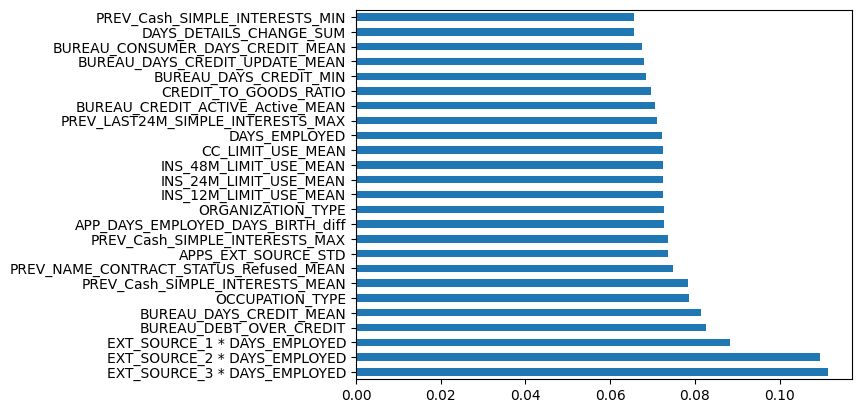

In [21]:
top20_positive=correlations.sort_values(ascending=False)[:25]
top20_positive.plot(kind='barh')

<Axes: >

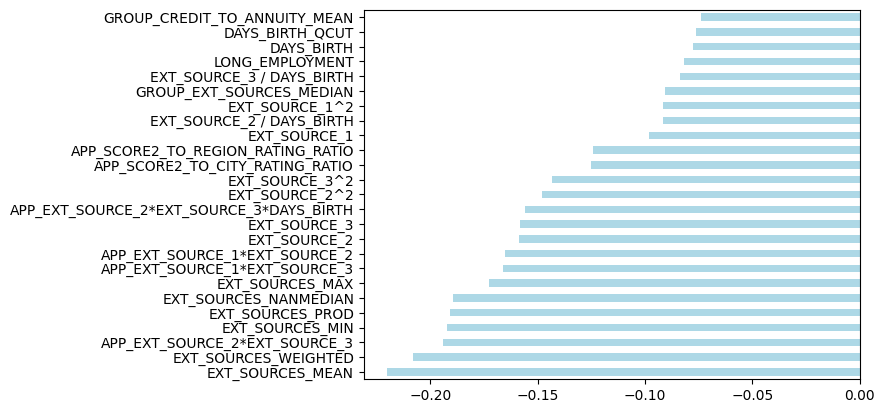

In [23]:
top20_negative=correlations.sort_values(ascending=True)[:25]
top20_negative.plot(kind='barh', color='lightblue')

Columns transformed from DAYS_BIRTH, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_1 are highly correlated to TARGET.

In [24]:
correlation_matrix = train_target.corr()

In [25]:
correlation_matrix

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,...,INS_24M_DPD_VAR,INS_24M_DBD_MAX,INS_24M_DBD_MEAN,INS_24M_DBD_VAR,INS_24M_DPD_7_MEAN,INS_24M_DPD_15_MEAN,INS_24M_LATE_PAYMENT_MEAN,INS_24M_LATE_PAYMENT_RATIO_MEAN,INS_24M_PAYMENT_DIFFERENCE_MEAN,INS_24M_PAYMENT_RATIO_MEAN,INS_24M_SIGNIFICANT_LATE_PAYMENT_MEAN,INS_60M_SK_ID_PREV_SIZE,INS_60M_AMT_INSTALMENT_MIN,INS_60M_AMT_INSTALMENT_MAX,INS_60M_AMT_INSTALMENT_MEAN,INS_60M_AMT_INSTALMENT_SUM,INS_60M_AMT_PAYMENT_MIN,INS_60M_AMT_PAYMENT_MAX,INS_60M_AMT_PAYMENT_MEAN,INS_60M_AMT_PAYMENT_SUM,INS_60M_DAYS_ENTRY_PAYMENT_MIN,INS_60M_DAYS_ENTRY_PAYMENT_MAX,INS_60M_DAYS_ENTRY_PAYMENT_MEAN,INS_60M_DPD_MAX,INS_60M_DPD_MEAN,INS_60M_DPD_VAR,INS_60M_DBD_MAX,INS_60M_DBD_MEAN,INS_60M_DBD_VAR,INS_60M_DPD_7_MEAN,INS_60M_DPD_15_MEAN,INS_60M_LATE_PAYMENT_MEAN,INS_60M_LATE_PAYMENT_RATIO_MEAN,INS_60M_PAYMENT_DIFFERENCE_MEAN,INS_60M_PAYMENT_RATIO_MEAN,INS_60M_SIGNIFICANT_LATE_PAYMENT_MEAN,LAST_LOAN_DPD_sum,LAST_LOAN_DPD_mean,LAST_LOAN_DPD_max,LAST_LOAN_DPD_std,LAST_LOAN_LATE_PAYMENT_count,LAST_LOAN_LATE_PAYMENT_mean,LAST_LOAN_PAID_OVER_AMOUNT_sum,LAST_LOAN_PAID_OVER_AMOUNT_mean,LAST_LOAN_PAID_OVER_AMOUNT_max,LAST_LOAN_PAID_OVER_AMOUNT_min,LAST_LOAN_PAID_OVER_AMOUNT_std,LAST_LOAN_PAID_OVER_count,LAST_LOAN_PAID_OVER_mean,TARGET
CNT_CHILDREN,1.000000,0.029807,0.002889,0.021941,-0.000946,-0.026915,-0.331834,0.049330,0.184033,-0.029352,1.164462e-03,0.241329,0.054705,-0.002713,-0.029914,0.022910,0.878803,0.025480,0.024931,-0.007070,-0.013321,0.008593,0.014845,0.021869,0.070410,0.068293,-0.097706,-0.017389,-0.037825,-0.000289,0.015963,-0.001001,-0.005185,0.000663,0.058561,-0.003622,-0.017716,-0.157519,-0.002415,0.050595,-0.001918,-0.002329,-0.005119,1.633188e-03,0.005831,-0.005074,0.003138,0.011008,-0.000713,0.005310,...,0.002101,-0.013658,-0.005837,-0.004352,0.009143,0.002757,-0.008431,-0.001566,0.012027,-0.003179,-0.009463,-0.030840,-0.013061,-0.018163,-0.019036,-0.043915,-0.014546,-0.018282,-0.019715,-0.044139,0.012241,-0.011451,0.001148,0.001764,0.007827,0.001511,-0.009374,-0.003373,-0.004540,0.012052,0.007581,-0.007030,-0.001452,0.013432,-0.004165,-0.008165,0.000289,0.005376,0.001232,0.004718,-0.018274,-0.007530,-0.009755,-0.011995,-0.012159,0.002690,-0.010690,-0.018274,-0.013587,0.019643
AMT_INCOME_TOTAL,0.029807,1.000000,0.409961,0.487757,0.415251,0.192448,-0.074212,-0.041141,0.076774,0.026752,9.859180e-04,0.175140,-0.049814,-0.015910,0.000285,0.101278,0.038570,-0.224370,-0.242412,0.091748,0.080303,0.165598,0.154722,0.012085,0.024917,0.028729,0.062296,0.171140,-0.071316,-0.032878,-0.027707,-0.033186,-0.063016,-0.001657,-0.031745,-0.000008,0.005278,-0.124662,0.002045,0.193056,0.042170,-0.000105,0.002772,1.502980e-03,0.054242,0.045081,0.024885,0.018454,0.008464,0.003229,...,-0.004043,0.005383,-0.056489,-0.003894,-0.022700,-0.023097,-0.067674,-0.002454,-0.067555,-0.003855,-0.064048,0.065773,0.099690,0.147052,0.191596,0.186342,0.073646,0.148249,0.185731,0.187485,-0.038060,0.017820,-0.016708,-0.010937,-0.021935,-0.007008,0.015944,-0.052030,0.002868,-0.021787,-0.024541,-0.066924,-0.000011,-0.072290,-0.004979,-0.063157,-0.011309,-0.019597,-0.011183,-0.015682,0.050129,-0.058529,

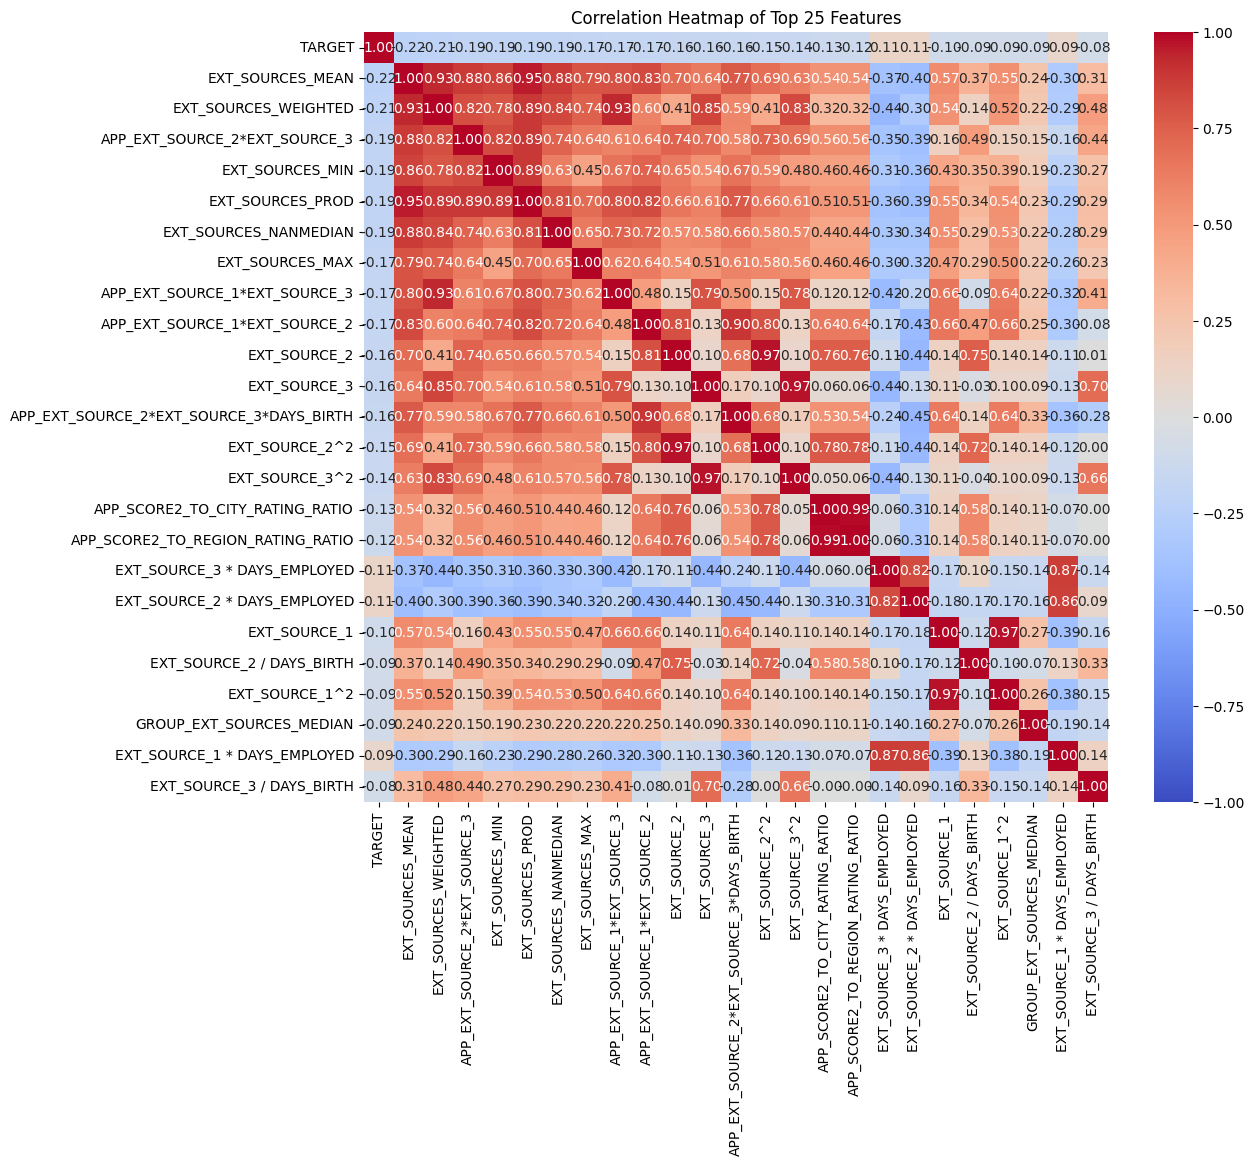

In [26]:
target_corr = correlation_matrix['TARGET'].abs().sort_values(ascending=False)  # Thay 'TARGET' bằng cột mục tiêu của bạn

# Lấy tên 25 biến có tương quan cao nhất
top_25_features = target_corr.head(25).index

# Tạo ma trận tương quan cho 25 biến này
top_25_corr_matrix = train_target[top_25_features].corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(top_25_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Top 25 Features")
plt.show()